In [2]:
import numpy as np
import subprocess
import random
from glob import glob
from skimage import io
from skimage.transform import rescale,resize,downscale_local_mean
import SimpleITK as sitk
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import math

In [3]:
# DCR Network 코드
#!/usr/bin/python
#!-*- coding:utf-8 -*-


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf


class Model( object ):

    def _conv2d( self, x_tensor, num_outputs, conv_ksize, strides=(1, 1), padding='valid', rate=(1, 1),  name=None ):
        return tf.layers.conv2d( x_tensor, num_outputs, conv_ksize, 
                                 strides=strides, 
                                 padding=padding, 
                                 # kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 dilation_rate=rate,
                                 name=name )


    def _deconv2d( self, x_tensor, num_outputs, conv_ksize, strides=(1, 1), padding='valid', name=None ):
        return tf.layers.conv2d_transpose( x_tensor, num_outputs, conv_ksize, 
            strides=strides, 
            padding=padding, 
            kernel_initializer=tf.contrib.layers.xavier_initializer(),
            name=name)


    def _deconv2d_with_relu( self, x_tensor, num_outputs, conv_ksize, strides=(1, 1), padding='valid', name=None ):
        res = tf.layers.conv2d_transpose( x_tensor, num_outputs, conv_ksize, 
            strides=strides, 
            padding=padding, 
            kernel_initializer=tf.contrib.layers.xavier_initializer(),
            name=name)
        return tf.nn.relu( res )


    def _max_pool( self, x_tensor, pool_ksize, strides=None, padding='valid', name=None ):
        if strides == None:
            strides = pool_ksize
        return tf.layers.max_pooling2d( x_tensor, pool_ksize, strides, padding=padding, name=name )


    def _avg_pool( self, x_tensor, pool_ksize, strides=None, padding='valid', name=None ):
        if strides == None:
            strides = pool_ksize
        return tf.layers.avg_pooling2d( net, pool_ksize, strides, padding=padding, name=name)


    def _bn( self, x_tensor, is_training=True, name=None ):
        return tf.layers.batch_normalization( x_tensor, training=is_training, name=name )


    def _relu( self, x_tensor, name=None ):
        return tf.nn.relu( x_tensor, name=name )


    def _conv_layer( self, x_tensor, num_outputs, ksize, strides=(1, 1), padding='valid', rate=(1, 1), name=None ):
        net = tf.layers.conv2d( x_tensor, num_outputs, ksize, 
                                 strides=strides, 
                                 padding=padding, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 dilation_rate=rate,
                                 name=name )
        return tf.nn.relu( net )


    def identity_block( self, x, kernel_size, filters, stage, block, is_training=True ):
        filters1, filters2, filters3 = filters
        conv_name_base = 'conv' + str(stage) + block + '_Res'
        bn_name_base = 'bn' + str(stage) + block + '_Res'

        net = self._conv2d( x, filters1, (1, 1), name='{}_2a'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_2a'.format(bn_name_base) )
        net = self._relu( net )

        net = self._conv2d( net, filters2, kernel_size, padding='same', name='{}_2b'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_2b'.format(bn_name_base) )
        net = self._relu( net )

        net = self._conv2d( net, filters3, (1, 1), name='{}_2c'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_2c'.format(bn_name_base) )

        net = tf.add( net, x )
        net = self._relu( net )
        return net


    def conv_block( self, x, kernel_size, filters, stage, block, strides=(2, 2), is_training=True ):
        filters1, filters2, filters3 = filters
        conv_name_base = 'conv' + str(stage) + block + '_Res'
        bn_name_base = 'bn' + str(stage) + block + '_Res'

        net = self._conv2d( x, filters1, (1, 1), strides=strides, name='{}_2a'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_2a'.format(bn_name_base) )
        net = self._relu( net )

        net = self._conv2d( net, filters2, kernel_size, padding='SAME', name='{}_2b'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_2b'.format(bn_name_base) )
        net = self._relu( net )

        net = self._conv2d( net, filters3, (1, 1), name='{}_2c'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_2c'.format(bn_name_base) )

        shortcut = self._conv2d( x, filters3, (1, 1), strides=strides, name='{}_1'.format(conv_name_base) )
        shortcut = self._bn( shortcut, is_training=is_training, name='{}_1'.format(bn_name_base) )

        net = tf.add( net, shortcut )
        net = self._relu( net )
        return net


    def ResNet50( self, x, base=128, is_training=True ):
        net = self._conv2d( x, 64, (7, 7), padding='SAME', name='conv1' )
        net = self._bn( net, is_training=is_training, name='bn_conv1' )
        net = self._relu( net )
        net = self._max_pool( net, (3, 3), strides=(2, 2) )

        net = self.conv_block( net, 3, [64, 64, base], stage=2, block='a' )
        net = self.identity_block( net, 3, [64, 64, base], stage=2, block='b' )
        sub1 = self.identity_block( net, 3, [64, 64, base], stage=2, block='c' )

        net = self.conv_block( sub1, 3, [128, 128, base * 2], stage=3, block='a' )
        net = self.identity_block( net, 3, [128, 128, base * 2], stage=3, block='b' )
        net = self.identity_block( net, 3, [128, 128, base * 2], stage=3, block='c' )
        sub2 = self.identity_block( net, 3, [128, 128, base * 2], stage=3, block='d' )

        net = self.conv_block( sub2, 3, [256, 256, base * 4], stage=4, block='a' )
        net = self.identity_block( net, 3, [256, 256, base * 4], stage=4, block='b' )
        net = self.identity_block( net, 3, [256, 256, base * 4], stage=4, block='c' )
        net = self.identity_block( net, 3, [256, 256, base * 4], stage=4, block='d' )
        net = self.identity_block( net, 3, [256, 256, base * 4], stage=4, block='e' )
        sub3 = self.identity_block( net, 3, [256, 256, base * 4], stage=4, block='f' )

        net = self.conv_block( sub3, 3, [512, 512, base * 8], stage=5, block='a') 
        net = self.identity_block( net, 3, [512, 512, base * 8], stage=5, block='b' )
        sub4 = self.identity_block( net, 3, [512, 512, base * 8], stage=5, block='c' )

        return sub1, sub2, sub3, sub4


    def _dcr_block_a( self, x, num_filter, para, stage, block, is_training=True ):
        # para : a 3-dim tuple(or list) like structure 
        #   para[0] - dilation rate
        #   para[1] - the kernel size of the left term which is a 1-by-1 convolution
        #   para[2] - the kernel size of the right term which is dilated convolution 
        rate = para[0]
        l_kconv = para[1]
        r_kconv = para[2]

        conv_name_base = 'conv' + str(stage) + block + '_DCR_A'
        bn_name_base = 'bn' + str(stage) + block + '_DCR_A'

        net_l = self._conv2d( x, num_filter, l_kconv, padding='SAME', name='{}_l'.format(conv_name_base) )
        net_l = self._bn( net_l, is_training=is_training, name='{}_l'.format(bn_name_base) )

        net_r = self._conv2d( x, num_filter, r_kconv, padding='SAME', rate=rate, name='{}_r'.format(conv_name_base) )
        net_r = self._bn( net_r, is_training=is_training, name='{}_r'.format(bn_name_base) )

        net = self._relu( tf.add( net_l, net_r ) )
        return net


    def _dcr_block_b( self, x, num_filter, para, stage, block, is_training=True ):
        kconv = para[1]

        conv_name_base = 'conv' + str(stage) + block + '_DCR_B'
        bn_name_base = 'bn' + str(stage) + block + '_DCR_B'

        net = self._conv2d( x, num_filter, kconv, padding='SAME', name='{}_term'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_term'.format(bn_name_base) )
        net = self._relu( net )
        return net 


    def _dcr_block_c( self, x, num_filter, para, stage, block, is_training=True ):
        rate = para[0]
        kconv = para[2]

        conv_name_base = 'conv' + str(stage) + block + '_DCR_C'
        bn_name_base = 'bn' + str(stage) + block + '_DCR_C'

        net = self._conv2d( x, num_filter, kconv, padding='SAME', rate=rate, name='{}_term'.format(conv_name_base) )
        net = self._bn( net, is_training=is_training, name='{}_term'.format(bn_name_base) )
        net = self._relu( net )
        return net 


    def DCR( self, inputs_x, filters, dcr_type, dilated_rates=None ):
        '''
            DCR
            type = A, B, C
        '''
        dcr_type = dcr_type.upper()

        assert dcr_type in ['A', 'B', 'C']
        if dcr_type in ['A', 'C']:
            assert isinstance(dilated_rates, list) or isinstance(dilated_rates, tuple) and len(dilated_rates) == 4
            r1, r2, r3, r4 = dilated_rates
        else:
            r1 = r2 = r3 = r4 = 0

        dcr_list = { 'A' : self._dcr_block_a,
                     'B' : self._dcr_block_b,
                     'C' : self._dcr_block_c }
        _dcr_block = dcr_list.get( dcr_type )

        s1, s2, s3, s4 = inputs_x
        f1, f2, f3, f4 = filters

        dcr1 = _dcr_block( s1, f1, [r1, 1, 3], stage=2, block='a' )
        dcr1 = self._conv2d( dcr1, f1, 1, name='conv2b_after_DCR_A' )

        dcr2 = _dcr_block( s2, f2, [r2, 1, 3], stage=3, block='a' )
        dcr2 = self._conv2d( dcr2, f2, 1, name='conv3b_after_DCR_A' )

        dcr3 = _dcr_block( s3, f3, [r3, 1, 3], stage=4, block='a' )
        dcr3 = self._conv2d( dcr3, f3, 1, name='conv4b_after_DCR_A' )

        dcr4 = _dcr_block( s4, f4, [r4, 1, 3], stage=5, block='a' )
        dcr4 = self._conv2d( dcr4, f4, 1, name='conv5b_after_DCR_A' )

        return dcr1, dcr2, dcr3, dcr4


    def Transpose( self, inputs_dcr ):
        d1, d2, d3, d4 = inputs_dcr
        base_name = 'deconv{}'
        net = self._deconv2d( d4, 64, 3, strides=2, padding='SAME', name=base_name.format(5) )
        print(net)

        net = tf.add( net, d3 )
        net = self._deconv2d( net, 64, 3, strides=2, padding='SAME', name=base_name.format(4) )
        print(net)

        net = tf.add( net, d2 )
        net = self._deconv2d( net, 64, 3, strides=2, padding='SAME', name=base_name.format(3) )
        print(net)

        net = tf.add( net, d1 )
        net = self._deconv2d( net, 64, 3, strides=2, padding='SAME', name=base_name.format(2) )
        print(net)

        net = self._deconv2d( net, 64, 3, strides=2, padding='SAME', name=base_name.format(1) )
        print(net)

        net = self._conv2d( net, 5, 1, name='restore_image' )
        print(net)
        return net


    def ResNet_DCR_Model( self, x, dcr_type, dilated_rates=None ):
        '''
            dilated_rates:
                [12, 6, 4, 1]
                [8, 4, 2, 1]
                [6, 3, 2, 1]
            self.DCR:
                'A', 'B', 'C'
        '''
        s1, s2, s3, s4 = self.ResNet50( x )
        d1, d2, d3, d4 = self.DCR( [s1, s2, s3, s4], [64 for i in range(4)], dcr_type, dilated_rates=dilated_rates )
        res = self.Transpose( [d1, d2, d3, d4] )
        return res


    def FCN( self, x ):
        # x  -  224 * 224

        # block 1
        net = self._conv_layer( x, 64, 3, padding='SAME', name='conv1_1' )
        net = self._conv_layer( net, 64, 3, padding='SAME', name='conv1_2' )
        net = self._max_pool( net, 2, padding='SAME', name='pool1' )
        # 112 * 112

        #block 2
        net = self._conv_layer( net, 128, 3, padding='SAME', name='conv2_1' )
        net = self._conv_layer( net, 128, 3, padding='SAME', name='conv2_2' )
        net = self._max_pool( net, 2, padding='SAME', name='pool2' )
        # 56 * 56

        # block 3
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv3_1' )
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv3_2' )
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv3_3' )
        score_pool3 = self._max_pool( net, 2, padding='SAME', name='pool3' )
        # print( score_pool3 )
        # 28 * 28

        # block 4
        net = self._conv_layer( score_pool3, 256, 3, padding='SAME', name='conv4_1' )
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv4_2' )
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv4_3' )
        score_pool4 = self._max_pool( net, 2, padding='SAME', name='pool4' )
        # print( score_pool4 )
        # 14 * 14

        # block 5
        net = self._conv_layer( score_pool4, 256, 3, padding='SAME', name='conv5_1' )
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv5_2' )
        net = self._conv_layer( net, 256, 3, padding='SAME', name='conv5_3' )
        score_pool5 = self._max_pool( net, 2, padding='SAME', name='pool5' )
        # print( score_pool5 )
        # 7 * 7

        upsampled5 = self._deconv2d( score_pool5, 256, 3, strides=2, padding='SAME', name='upsampled5' )
        add_4and5 = tf.add( score_pool4, upsampled5 )
        # 14 * 14

        upsampled4 = self._deconv2d( add_4and5, 256, 3, strides=2, padding='SAME', name='upsampled4' )
        add_3and4 = tf.add( score_pool3, upsampled4 )
        # 28 * 28

        # for add_3and4, to upsampled 8x
        upsampled_8x = self._deconv2d_with_relu( add_3and4, 128, 3, strides=2, padding='SAME', name='upsampled3_8x_a' ) # 56 * 56
        upsampled_8x = self._deconv2d_with_relu( upsampled_8x, 64, 3, strides=2, padding='SAME', name='upsampled3_8x_b' ) # 112 * 112
        upsampled_8x = self._deconv2d( upsampled_8x, 64, 3, strides=2, padding='SAME', name='upsampled3_8x_c' ) # 224 * 224

        # for add_4and5, to upsampled 16x
        upsampled_16x = self._deconv2d_with_relu( add_4and5, 128, 3, strides=2, padding='SAME', name='upsampled3_16x_a' )# 28 * 28
        upsampled_16x = self._deconv2d_with_relu( upsampled_16x, 64, 3, strides=2, padding='SAME', name='upsampled3_16x_b' ) # 56 * 56
        upsampled_16x = self._deconv2d_with_relu( upsampled_16x, 64, 3, strides=2, padding='SAME', name='upsampled3_16x_c' ) # 112 * 112
        upsampled_16x = self._deconv2d( upsampled_16x, 64, 3, strides=2, padding='SAME', name='upsampled3_16x_d' ) # 224 * 224

        net = tf.add( upsampled_8x, upsampled_16x)

        # for score_pool5, to upsampled 32x
        upsampled_32x = self._deconv2d_with_relu( score_pool5, 128, 3, strides=2, padding='SAME', name='upsampled3_32x_a' ) # 14 * 14
        upsampled_32x = self._deconv2d_with_relu( upsampled_32x, 64, 3, strides=2, padding='SAME', name='upsampled3_32x_b' ) # 28 * 28
        upsampled_32x = self._deconv2d_with_relu( upsampled_32x, 64, 3, strides=2, padding='SAME', name='upsampled3_32x_c' ) # 56 * 56
        upsampled_32x = self._deconv2d_with_relu( upsampled_32x, 64, 3, strides=2, padding='SAME', name='upsampled3_32x_d' ) # 112 * 112
        upsampled_32x = self._deconv2d( upsampled_32x, 64, 3, strides=2, padding='SAME', name='upsampled3_32x_e' ) # 224 * 224

        net = tf.add( net, upsampled_32x )
        net = self._conv2d( net, 5, 1, name='fcn_output')
        return net


    def Unet( self, x, keep_prob=0.5 ):
        # 224 * 224

        # stage 1
        conv1 = self._conv_layer( x, 64, 3, padding='SAME', name='stage_1_conv_a' )
        conv1 = self._conv_layer( conv1, 64, 3, padding='SAME', name='stage_1_conv_b' ) # 224
        pool1 = self._max_pool( conv1, 2, padding='SAME', name='stage_1_pool' ) # 112

        # stage 2
        conv2 = self._conv_layer( pool1, 128, 3, padding='SAME', name='stage_2_conv_a' )
        conv2 = self._conv_layer( conv2, 128, 3, padding='SAME', name='stage_2_conv_b' ) # 112
        pool2 = self._max_pool( conv2, 2, padding='SAME', name='stage_2_pool' ) # 56

        # stage 3
        conv3 = self._conv_layer( pool2, 256, 3, padding='SAME', name='stage_3_conv_a' )
        conv3 = self._conv_layer( conv3, 256, 3, padding='SAME', name='stage_3_conv_b' ) # 56
        pool3 = self._max_pool( conv3, 2, padding='SAME', name='stage_3_pool' ) # 28

        # stage 4
        conv4 = self._conv_layer( pool3, 512, 3, padding='SAME', name='stage_4_conv_a' )
        conv4 = self._conv_layer( conv4, 512, 3, padding='SAME', name='stage_4_conv_b' )
        # drop4 = tf.nn.dropout( conv4, keep_prob=keep_prob )
        pool4 = self._max_pool( drop4, 2, padding='SAME', name='stage_4_pool' ) # 14

        # stage 5
        conv5 = self._conv_layer( pool4, 1024, 3, padding='SAME', name='stage_5_conv_a' )
        conv5 = self._conv_layer( conv5, 1024, 3, padding='SAME', name='stage_5_conv_b' ) # 14
        # drop5 = tf.nn.dropout( conv5, keep_prob=keep_prob )
        deconv5 = self._deconv2d_with_relu( conv5, 512, 3, strides=2, padding='SAME', name='stage_5_deconv' ) # 28

        # stage 6
        merge6 = tf.concat( [drop4, deconv5], -1, name='merge6' )
        conv6 = self._conv_layer( merge6, 512, 3, padding='SAME', name='stage_6_conv_a' )
        conv6 = self._conv_layer( merge6, 512, 3, padding='SAME', name='stage_6_conv_b' )
        deconv6 = self._deconv2d_with_relu( conv6, 256, 3, strides=2, padding='SAME', name='stage_6_deconv' ) # 56 

        # stage 7
        merge7 = tf.concat( [conv3, deconv6], -1, name='merge7' )
        conv7 = self._conv_layer( merge7, 256, 3, padding='SAME', name='stage_7_conv_a' )
        conv7 = self._conv_layer( conv7, 256, 3, padding='SAME', name='stage_7_conv_b' )
        deconv7 = self._deconv2d_with_relu( conv7, 128, 3, strides=2, padding='SAME', name='stage_7_deconv' ) # 112

        # stage 8
        merge8 = tf.concat( [conv2, deconv7], -1, name='merge8' )
        conv8 = self._conv_layer( merge8, 128, 3, padding='SAME', name='stage_8_conv_a' )
        conv8 = self._conv_layer( conv8, 128, 3, padding='SAME', name='stage_8_conv_b' )
        deconv8 = self._deconv2d_with_relu( conv8, 64, 3, strides=2, padding='SAME', name='stage_8_deconv' ) # 224

        # stage 9
        merge9 = tf.concat( [conv1, deconv8], -1, name='merge9' )
        conv9 = self._conv_layer( merge9, 64, 3, padding='SAME', name='stage_9_conv_a' )
        conv9 = self._conv_layer( conv9, 64, 3, padding='SAME', name='stage_9_conv_b' )
        conv9 = self._conv_layer( conv9, 5, 3, padding='SAME', name='output' )

        return conv9



#if __name__ == '__main__':
#    x = tf.placeholder( tf.float32, [None, 224, 224, 4] )
#
#    # k = Model().ResNet_DCR_Model( x, 'A', [3, 3, 3, 3])
#    # print(k)
#
#    # fcn = Model().FCN( x )
#    # print( fcn )
#
#    unet = Model().Unet( x )
#    print( unet )


/Users/donghoon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#파일 읽어오기
file_name_image = '/Users/donghoon/공부자료/포스텍정보통신연구소연구부/공모전/sample/sample_cardiac/CHD/image/**.mha'
file_name_label = '/Users/donghoon/공부자료/포스텍정보통신연구소연구부/공모전/sample/sample_cardiac/CHD/label/**.mha'


In [5]:
# 파일리스트 정렬하기
file_list_image = sorted(glob(file_name_image))
file_list_label = sorted(glob(file_name_label))
print(file_list_image)
print(file_list_label)

['/Users/donghoon/공부자료/포스텍정보통신연구소연구부/공모전/sample/sample_cardiac/CHD/image/sample_dia.mha', '/Users/donghoon/공부자료/포스텍정보통신연구소연구부/공모전/sample/sample_cardiac/CHD/image/sample_sys.mha']
['/Users/donghoon/공부자료/포스텍정보통신연구소연구부/공모전/sample/sample_cardiac/CHD/label/sample_dia_M.mha', '/Users/donghoon/공부자료/포스텍정보통신연구소연구부/공모전/sample/sample_cardiac/CHD/label/sample_sys_M.mha']


In [6]:
#파일 인덱스 0 읽어오기 & 정보 보기
image = sitk.ReadImage(str(file_list_image[0]))
label = sitk.ReadImage(str(file_list_label[0]))
print(sitk.GetArrayFromImage(image).shape)
print(sitk.GetArrayFromImage(label).shape)
print(image.GetPixelIDTypeAsString())
print(label.GetPixelIDTypeAsString())
print(image.GetSpacing())
print(label.GetSpacing())

(171, 512, 512)
(171, 512, 512)
16-bit signed integer
8-bit unsigned integer
(0.21875, 0.21875, 0.400024)
(1.0, 1.0, 1.0)


In [52]:
label_3ch = sitk.Image()
label_3ch = image
print(label_3ch)
print(image)

Image (0x7fd875f92180)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 981
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 955
  UpdateMTime: 980
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 171]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 171]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 171]
  Spacing: [0.21875, 0.21875, 0.400024]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.21875 0 0
0 0.21875 0
0 0 0.400024

  PointToIndexMatrix: 
4.57143 0 0
0 4.57143 0
0 0 2.49985

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x7fd875f47f70)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Referenc

(0.4, 0.6, 0.6)
(68, 307, 307)


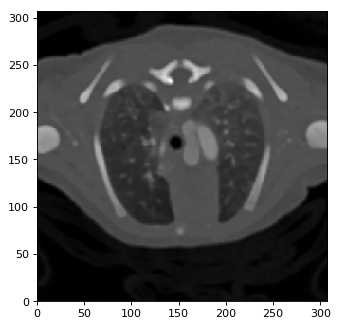

In [75]:
from scipy import ndimage
label_dummy = sitk.ReadImage(str(file_list_label[0]))
image_np_dummy = sitk.GetArrayFromImage(image_dummy)
resize_factor1 = image_dummy.GetSpacing()[::-1]
print(resize_factor1)
image_np_dummy = ndimage.zoom(image_np_dummy,resize_factor1,order=0,mode='constant',cval=0.0)
print(image_np_dummy.shape)
label4 = sitk.GetImageFromArray(image_np_dummy)
myshow2d(label4[:,:,50])

In [71]:
image_1 =sitk.ReadImage(str(file_list_image[0]))
image_2 = sitk.ReadImage(str(file_list_label[0]))
print(image_1.GetSpacing(),image_2.GetSpacing())
resampled_image_1 = resample_POS572(image_1,image_1.GetSpacing())
resampled_image_2 = resample_POS572_Mask(image_2,image_2.GetSpacing())
print(resampled_image_1.GetSize())
print(resampled_image_2.GetSize())

(0.21875, 0.21875, 0.400024) (1.0, 1.0, 1.0)
(512, 512, 171)
(512, 512, 171)


In [72]:
print(resampled_image_1.GetSpacing())
print(resampled_image_2.GetSpacing())

(0.21875, 0.21875, 0.400024)
(1.0, 1.0, 1.0)


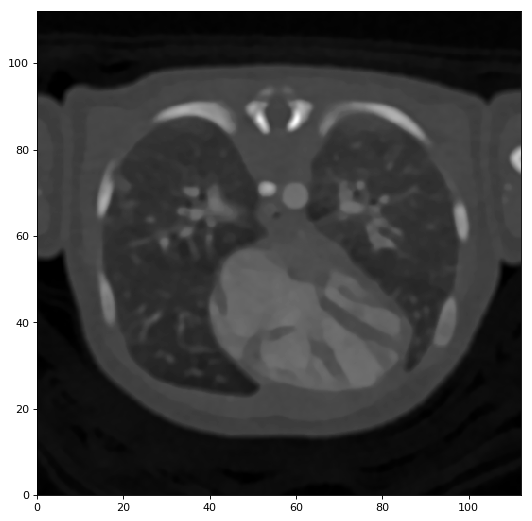

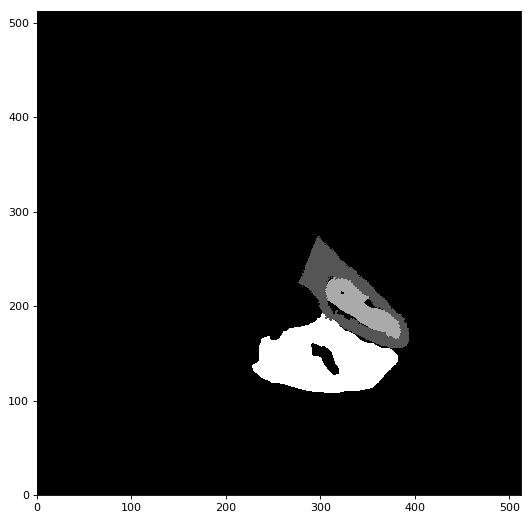

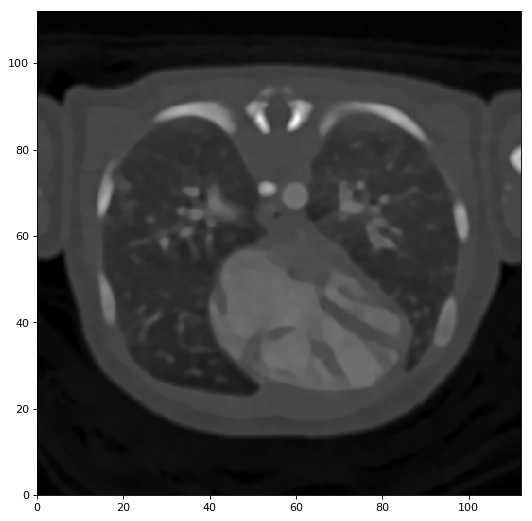

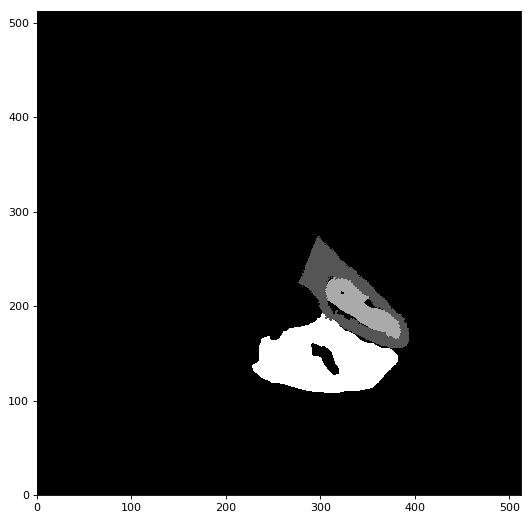

In [73]:
myshow2d(image_1[:,:,50])
myshow2d(image_2[:,:,50])
myshow2d(resampled_image_1[:,:,50])
myshow2d(resampled_image_2[:,:,50])

In [8]:
# 변수 지정
dimension = 3
point = (1.0, 1.0,1.0)
LowT = -1000
HighT = 400
displacement = 10
n_class =3
img_rows=512
img_cols=512

In [9]:
# 포인트 Transform 좌표 프린트하기
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print('Point '+str(point) + ' transformed is ' + str(transformed_point))

In [10]:
# 없어도 되는 코드
print('*Translation Transform*')
translation = sitk.TranslationTransform(dimension)

print('Parameters : '+ str(translation.GetParameters()))
print('Offset : '+ str(translation.GetOffset()))
print('FixedParameters: '+ str(translation.GetFixedParameters()))
transform_point(translation,point)

print('')
#translation.SetParameters((3.1,4.4,5.3))
print('Parameters : '+ str(translation.GetParameters()))
transform_point(translation, point)

*Translation Transform*
Parameters : (0.0, 0.0, 0.0)
Offset : (0.0, 0.0, 0.0)
FixedParameters: ()
Point (1.0, 1.0, 1.0) transformed is (1.0, 1.0, 1.0)

Parameters : (0.0, 0.0, 0.0)
Point (1.0, 1.0, 1.0) transformed is (1.0, 1.0, 1.0)


In [11]:
# 2D 이미지 보여주기
def myshow2d(img, title = None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    
    ysize = nda.shape[0]
    xsize = nda.shape[1]
    
    figsize = (1+margin) * ysize /dpi, (1+margin) * xsize /dpi
    
    fig = plt.figure(title, figsize = figsize , dpi = dpi)
    ax = fig.add_axes([margin,margin,1 - 2*margin, 1-2*margin])
    
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda, extent=extent, cmap= 'gray', origin='lower')
    if(title):
        plt.title(title)
    plt.show()

In [12]:
# 2D 이미지 보여주기
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()

# 3D 이미지 보여주기
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

In [13]:
# 쓰지않는 함수 
def resample(image, new_spacing):
    # Output image Origin, Spacing, Size, Direction 들은 레퍼런스에서 가져옵니다.
    new_size = (512,512,512)
    image = image.SetSpacing(new_spacing[0],new_spacing[1],new_spacing[2])
    transform = sitk.Transform(3, sitk.sitkIdentity)
    interpolator = sitk.sitkCosineWindowedSinc
    resize_factor=np.array(image.GetSpacing())/np.array(new_spacing)
    new_real_shape = np.array(image.GetSize())*resize_factor
    new_shape = np.array(np.round(new_real_shape),np.uint32)
    new_size = (int(new_shape[0]),int(new_shape[1]),int(new_shape[2]))
    origin = image.GetOrigin()
    new_spacing = new_spacing
    direction = image.GetDirection()
    #return sitk.Resample(image, reference_image, transform, interpolator, default_value)
    return sitk.Resample(image,new_size , transform, interpolator, origin, new_spacing, direction)

In [14]:
# 이미지 spacing 1.0,1.0,1.0으로 지정후 resample
label.SetSpacing(image.GetSpacing())
print(label.GetSpacing())
#test_image = sitk_resample_to_spacing(image,(0.5,0.5,0.5))

(0.21875, 0.21875, 0.400024)


In [15]:
# 레이블 spacing 1.0,1.0,1.0 인 처음 상태에서 resample
#test_label = sitk_resample_to_spacing(label,(0.5,0.5,0.5))

In [16]:
# # 이미지 사이즈. 스페이싱 출력
# print(test_image.GetSize())
# print(test_image.GetSpacing())
# print(resampled_img.GetSize())
# print(resampled_img.GetSpacing())
# myshow2d(test_image[:,:,100])
# myshow2d(resampled_img[:,:,100])

In [17]:
# resample 제작한 함수
def resample_POS572(image, new_spacing):
    # Output image Origin, Spacing, Size, Direction 들은 레퍼런스에서 가져옵니다.
    transform = sitk.Transform(3, sitk.sitkIdentity)
    interpolator = sitk.sitkBSpline
    resize_factor=np.array(image.GetSpacing())/np.array(new_spacing)
    new_real_shape = np.array(image.GetSize())*resize_factor
    new_shape = np.array(np.round(new_real_shape),np.uint32)
    new_size = (int(new_shape[0]),int(new_shape[1]),int(new_shape[2]))
    origin = image.GetOrigin()
    new_spacing = new_spacing
    direction = image.GetDirection()
    #return sitk.Resample(image, reference_image, transform, interpolator, default_value)
    return sitk.Resample(image,new_size , transform, interpolator, origin, new_spacing, direction)

In [18]:
# resample 제작한 함수
def resample_POS572_Mask(image, new_spacing):
    # Output image Origin, Spacing, Size, Direction 들은 레퍼런스에서 가져옵니다.
    transform = sitk.Transform(3, sitk.sitkIdentity)
    interpolator = sitk.sitkNearestNeighbor
    resize_factor=np.array(image.GetSpacing())/np.array(new_spacing)
    new_real_shape = np.array(image.GetSize())*resize_factor
    new_shape = np.array(np.round(new_real_shape),np.uint32)
    new_size = (int(new_shape[0]),int(new_shape[1]),int(new_shape[2]))
    origin = image.GetOrigin()
    new_spacing = new_spacing
    direction = image.GetDirection()
    #return sitk.Resample(image, reference_image, transform, interpolator, default_value)
    return sitk.Resample(image,new_size , transform, interpolator, origin, new_spacing, direction)

In [19]:
sample = {'image':image,'label':label}

In [20]:
def test(sample,new_spacing):
    image,label = sample['image'],sample['label']
   #statFilter = sitk.StatisticsImageFilter()
   #statFilter.Execute(label)
   #print('Before Resample Label GetMaximum :' + str(statFilter.GetMaximum()))
    npLabel = sitk.GetArrayFromImage(label)
    value, count = np.unique(npLabel, return_counts=True)
    print('Origin Label value : ' + str(value) + '  Origin Label Count : ' + str(count))

    old_spacing = image.GetSpacing()
    old_size = image.GetSize()
    #print(str(old_spacing))
    new_spacing = new_spacing
    new_size = []

    for i in range(3):
        new_size.append(int(math.ceil(old_spacing[i]*old_size[i]/new_spacing[i])))
    new_size = tuple(new_size)

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkBSpline)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)

    # resample on image
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())

    print("Resampling image...")
    image = resampler.Execute(image)

    # resample on segmentation
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputOrigin(label.GetOrigin())
    resampler.SetOutputDirection(label.GetDirection())
    print(resampler)
    print("Resampling segmentation...")
    resampled_label = resampler.Execute(label)

    print('ReSampled Image Size :'+str(image.GetSize())+' ReSampled Label Size :'+str(resampled_label.GetSize()))
   # statFilter = sitk.StatisticsImageFilter()
   # statFilter.Execute(label)
    npLabel = sitk.GetArrayFromImage(resampled_label)
    value,count = np.unique(npLabel,return_counts=True)
    print('Resampled Label value : '+str(value)+'  Resampled Label Count : '+ str(count))
    #print('After Resample Label GetMaximum :' + str(statFilter.GetMaximum()))
    return {'image': image, 'label': resampled_label}

In [21]:
sample = test(sample,(0.5,0.5,0.5))

Origin Label value : [0 1 2 3]  Origin Label Count : [44178540   124648    64844   458592]
Resampling image...
itk::simple::ResampleImageFilter
  Size: [ 224, 224, 137 ]
  Interpolator: NearestNeighbor
  OutputOrigin: [ 0, 0, 0 ]
  OutputSpacing: [ 0.5, 0.5, 0.5 ]
  OutputDirection: [ 1, 0, 0, 0, 1, 0, 0, 0, 1 ]
  DefaultPixelValue: 0
  OutputPixelType: Unknown pixel id
  Debug: 0
  NumberOfThreads: 8
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)

Resampling segmentation...
ReSampled Image Size :(224, 224, 137) ReSampled Label Size :(224, 224, 137)
Resampled Label value : [0 1 2 3]  Resampled Label Count : [6774871   19059    9880   70302]


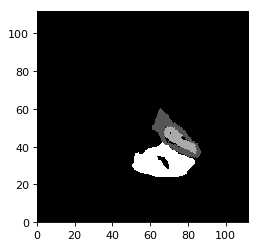

In [22]:
image1=sample['image']
label1 = sample['label']
myshow2d(label1[:,:,40])

In [23]:
# 이미지데이터 0.5 spacing으로 resample하기
resampled_img = resample_POS572(image,(0.5,0.5,0.5))

In [24]:
# 레이블 데이터 0.5 spacing으로 resample하기
resampled_label = resample_POS572_Mask(label,(0.5,0.5,0.5))

In [25]:
print(image.GetSize())
print(label.GetSize())
print(image.GetSpacing())
print(label.GetSpacing())
print(resampled_img.GetSize())
print(resampled_label.GetSize())
print(resampled_img.GetSpacing())
print(resampled_label.GetSpacing())

(512, 512, 171)
(512, 512, 171)
(0.21875, 0.21875, 0.400024)
(0.21875, 0.21875, 0.400024)
(224, 224, 137)
(224, 224, 137)
(0.5, 0.5, 0.5)
(0.5, 0.5, 0.5)


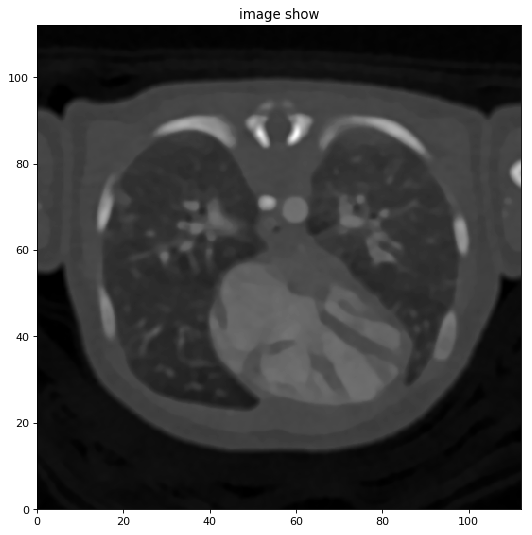

In [26]:
# 이미지 확인 (axial)
myshow2d(image[:,:,50],'image show')


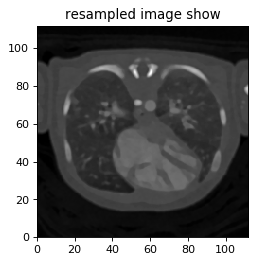

In [27]:
# resample된 이미지 확인(axial)
myshow2d(resampled_img[:,:,40], 'resampled image show')


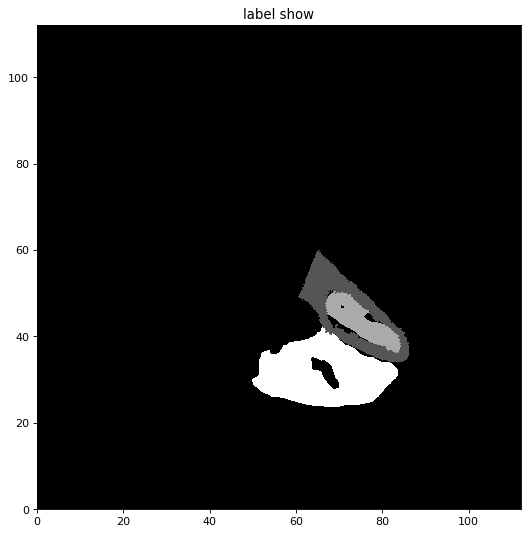

In [28]:
# 레이블 확인(axial)
myshow2d(label[:,:,50],'label show')

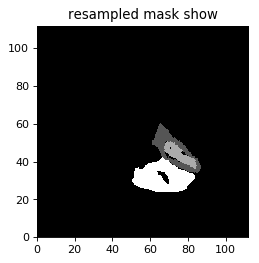

(224, 224, 137)


In [29]:
# resample된 레이블 확인(axial)
myshow2d(resampled_label[:,:,40], 'resampled mask show')
print(resampled_label.GetSize())

In [30]:
statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(resampled_label)
print(statFilter.GetSum())
print(statFilter.GetMaximum())

249725.0
3.0


In [31]:
# 512,512 사이즈로 resize해서 resample하기 
def resample_resize2D(image, rc ):
    rows=rc[0]
    cols=rc[1]
    #print(rows,cols)
    newe_size= (rows,cols)
    prior_cols=image.GetWidth()
    prior_rows=image.GetHeight()
    affine = sitk.AffineTransform(2)
    matrix = np.array(affine.GetMatrix()).reshape((2,2))
    matrix[0,0] = float(prior_cols)/cols
    matrix[1,1]= float(prior_rows)/rows
    affine.SetMatrix(matrix.ravel())
    interpolator = sitk.sitkCosineWindowedSinc
    origin = image.GetOrigin()
    new_spacing = image.GetSpacing()
    direction = image.GetDirection()
    #return sitk.Resample(image, new_size , new_transform, interpolator, origin,new_spacing,direction)
    return sitk.Resample(image,(512,512) , affine, interpolator, origin, new_spacing, direction)


In [32]:
# 512,512 사이즈로 resize해서 resample하기 
def resample_resizeMask2D(image, rc ):
    rows=rc[0]
    cols=rc[1]
    newe_size= (rows,cols)
    prior_cols=image.GetWidth()
    prior_rows=image.GetHeight()
    affine = sitk.AffineTransform(2)
    matrix = np.array(affine.GetMatrix()).reshape((2,2))
    matrix[0,0] = float(prior_cols)/cols
    matrix[1,1]= float(prior_rows)/rows
    affine.SetMatrix(matrix.ravel())
    interpolator = sitk.sitkCosineWindowedSinc
    origin = image.GetOrigin()
    new_spacing = image.GetSpacing()
    direction = image.GetDirection()
    #return sitk.Resample(image, new_size , new_transform, interpolator, origin,new_spacing,direction)
    return sitk.Resample(image,(512,512) , affine, interpolator, origin, new_spacing, direction)

In [33]:
# class 4개(배경, LVM, LV, RV)로 배열 만들어 sitk로 반환하기
def label_Mask_3ch(image):
    width = image.GetSize()[0]
    height = image.GetSize()[1]
    rgbImage = sitk.LabelToRGB(image)
    npImage = sitk.GetArrayFromImage(rgbImage)
    LV , RV, LVM = np.array((0,0,255)), np.array((0,255,255)),np.array((0,205,0))  
    black,red,green,blue =np.array((0,0,0)), np.array((255,0,0)),np.array((0,255,0)),np.array((0,0,))
    #print(npImage.shape)
    for i in range(0,width):
        for j in range(0,height):
            if RV[1] == npImage[j,i][1]:
                npImage[j,i]= blue
            elif LV[1] == npImage[j,i][1] and LV[2]==npImage[j,i][2]:
                npImage[j,i]= green
            elif LVM[1] == npImage[j,i][1] and LVM[2]==npImage[j,i][2]:
                npImage[j,i]= red
            else :
                npImage[j,i]=black
    new_image = sitk.GetImageFromArray(npImage)
    new_image.SetSpacing((0.5,0.5,0.5))
    return new_image
            

In [34]:
# class 4개(배경, LVM, LV, RV)로 배열 만들어 sitk로 반환하기
def label_Mask_3ch_test(image):
    width = image.GetSize()[0]
    height = image.GetSize()[1]
    npImage = sitk.GetArrayFromImage(image)
    Back,LV , RV, LVM = np.array(0),np.array(1), np.array(2),np.array(3)  
    black,red,green,blue =np.array((1,0,0,0)), np.array((0,1,0,0)),np.array((0,0,1,0)),np.array((0,0,0,1))
    #print(npImage.shape)
    for i in range(0,width):
        for j in range(0,height):
            if RV == npImage[j,i]:
                npImage[j,i]= blue
            elif LV == npImage[j,i] and LV==npImage[j,i]:
                npImage[j,i]= green
            elif LVM == npImage[j,i] and LVM==npImage[j,i]:
                npImage[j,i]= red
            else :
                npImage[j,i]=black
    new_image = sitk.GetImageFromArray(npImage)
    new_image.SetSpacing((0.5,0.5))
    return new_image

In [35]:
pos572_img_hu = sitk.Cast(sitk.IntensityWindowing(resampled_img,LowT,HighT,0,255),sitk.sitkUInt8)
size3d = pos572_img_hu.GetSize()
size2d = (size3d[0],size3d[1],0)
size3d_label = resampled_label.GetSize()
size2d_label = (size3d_label[0],size3d_label[1],0)
outimg = sitk.Image(resampled_img.GetSize(),sitk.sitkUInt8)
outimg.SetDirection(resampled_img.GetDirection())
outimg.SetSpacing(resampled_img.GetSpacing())
outimg.SetOrigin(resampled_img.GetOrigin())        
outimage_array = sitk.GetArrayFromImage(outimg)
        
num_of_slices = pos572_img_hu.GetDepth()
print(num_of_slices)
test_index = 100
#for i in range(num_of_slices):
for i in range(test_index,test_index+1):
    prev_idx = (0,0,i-displacement)
    cur_idx = (0,0,i)
    next_idx = (0,0,i+displacement)
    
    if(prev_idx[2]<0) or (next_idx[2]>=num_of_slices):
        continue
    
    pre_image = sitk.Extract(pos572_img_hu,size2d,prev_idx)
    cur_image = sitk.Extract(pos572_img_hu,size2d,cur_idx)
    next_image = sitk.Extract(pos572_img_hu,size2d,next_idx)
    
    mask2d = sitk.Extract(resampled_label,size2d_label,cur_idx)
    
    #512 * 512로 추출한 영상들 resize 하기
    prev_image_resample = resample_resize2D(pre_image,(img_rows,img_cols))
    cur_image_resample = resample_resize2D(cur_image,(img_rows,img_cols))
    next_image_resample = resample_resize2D(next_image,(img_rows,img_cols))
    
    mask2d_resample = resample_resizeMask2D(mask2d,(img_rows,img_cols))
    mask_final = label_Mask_3ch(mask2d_resample)
    rgbImage = sitk.Compose(prev_image_resample, cur_image_resample, next_image_resample)
    #print(rgbImage[50,50,50])
    image_train_arr = sitk.GetArrayFromImage(rgbImage)
    label_train_arr = sitk.GetArrayFromImage(mask_final)
    
    image_training = image_train_arr.reshape((1,img_rows,img_cols,3))
    label_training = label_train_arr.reshape((1,img_rows,img_cols,3))

    #myshow(sitk.LabelOverlay(cur_image_resample, mask2d_resample), title="Label Overlayed")
    print(image_training.shape)
    print(label_training.shape)
    

    #myshow(sitk.LabelOverlay(prev_image_resample, mask_final), title="Label Overlayed")
    #model.train_on_batch(image_training, label_training)
    
    
    

137
(1, 512, 512, 3)
(1, 512, 512, 3)


In [36]:
compare_index =(test_index*pos572_img_hu.GetDepth())/image.GetDepth()
print(int(compare_index) )
#myshow2d(image[:,:,50])
#myshow2d(label[:,:,50])
#myshow2d(prev_image_resample)
#myshow2d(pos572_img_hu[:,:,40])
#myshow2d(resampled_img[:,:,40])
#myshow2d(image[:,:,50])
#myshow2d(image[:,:,int(compare_index)])
#myshow2d(image[:,:,40])
#myshow2d(label[:,:,40])
print(prev_image_resample.GetSize())

80
(512, 512)


In [37]:
if len(file_list_image)==len(file_list_label):
    indices_t = len(file_name_image)
    print("The image matches the label.")
else :
    print("Image and label do not match")

The image matches the label.


In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
labels = [
    ("label","lv"),
    ("label","rv"),
    ("label","lvm"),
    ("back","back")
 ]
mlb = MultiLabelBinarizer()
print(mlb.fit(labels))
print(mlb.classes_)
print(mlb.transform([('label','lv')]))

MultiLabelBinarizer(classes=None, sparse_output=False)
['back' 'label' 'lv' 'lvm' 'rv']
[[0 1 1 0 0]]


In [39]:
def StatisticNormalization(image,sigma):
   statisticsFilter = sitk.StatisticsImageFilter()
   statisticsFilter.Execute(image)

   intensityWindowingFilter = sitk.IntensityWindowingImageFilter()
   intensityWindowingFilter.SetOutputMaximum(255)
   intensityWindowingFilter.SetOutputMinimum(0)
   intensityWindowingFilter.SetWindowMaximum(statisticsFilter.GetMean()+4*sigma*statisticsFilter.GetSigma());
   intensityWindowingFilter.SetWindowMinimum(statisticsFilter.GetMean()-0.5*sigma*statisticsFilter.GetSigma());

   image = intensityWindowingFilter.Execute(image)

   return image

In [40]:
def StatisticNormalization_basic(image,sigma):
   statisticsFilter = sitk.StatisticsImageFilter()
   statisticsFilter.Execute(image)

   intensityWindowingFilter = sitk.IntensityWindowingImageFilter()
   intensityWindowingFilter.SetOutputMaximum(255)
   intensityWindowingFilter.SetOutputMinimum(0)
   intensityWindowingFilter.SetWindowMaximum(statisticsFilter.GetMean()+sigma*statisticsFilter.GetSigma());
   intensityWindowingFilter.SetWindowMinimum(statisticsFilter.GetMean()-sigma*statisticsFilter.GetSigma());

   image = intensityWindowingFilter.Execute(image)

   return image

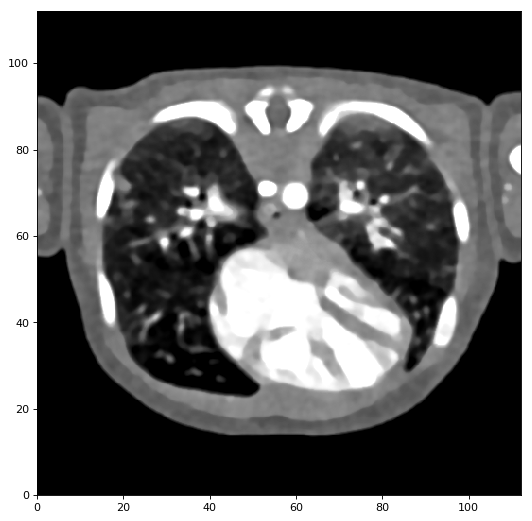

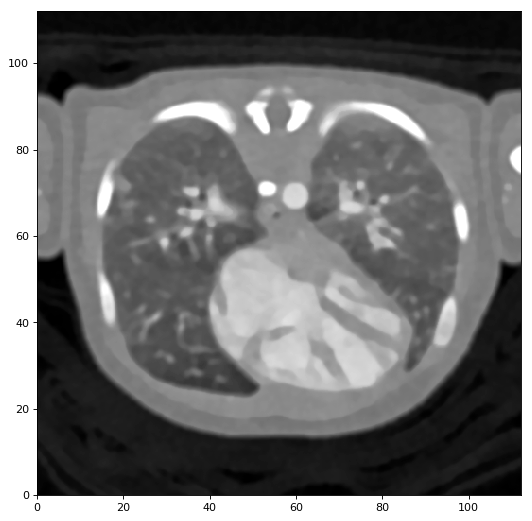

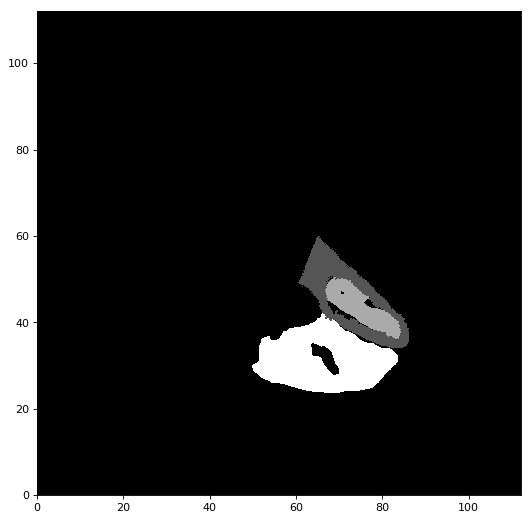

In [41]:
normalized_image = StatisticNormalization(image,0.4)
normalized_image2 = StatisticNormalization_basic(image,2.5)
myshow2d(normalized_image[:,:,50])
myshow2d(normalized_image2[:,:,50])
myshow2d(label[:,:,50])

In [42]:
def CT_calculate_mean_sd(image,label):
    arImage = sitk.GetArrayFromImage(image)
    arLabel = sitk.GetArrayFromImage(label)
    
    roi_mean = np.mean(arImage[arLabel !=0])
    roi_sd = np.std(arImage[arLabel!=0])
    
    return roi_mean, roi_sd


In [43]:
mean,std = CT_calculate_mean_sd(image,label)
print(mean)
print(std)

429.64494417390335
186.39013519948494


In [44]:
test_image = sitk.GetArrayFromImage(image)
test_label = sitk.GetArrayFromImage(label)
mask_dummy = test_label.copy()
mask_dummy = np.transpose(mask_dummy,(2,1,0))
#mask_dummy = np.sum(mask_dummy,axis = -1)
coordinates = np.argwhere(mask_dummy !=0)
coordinates_n = np.argwhere(mask_dummy==0)

print(coordinates.shape) # np.argwhere(array) => shape[0],shape[1]에서 0이 아닌 값을 가진 shape[0],shape[1]값을 가진 배열로 재지정
print(coordinates_n.shape) # mask_dummy중 0인 값들이 위치한 z,y값을 저장 . (z,y,x)였으므로
print(test_label.shape)
print(mask_dummy.shape)

(648084, 3)
(44178540, 3)
(171, 512, 512)
(512, 512, 171)


In [45]:
start_end = [[np.min(coordinates[:,0]),np.max(coordinates[:,0])],
                     [np.min(coordinates[:,1]),np.max(coordinates[:,1])],
                     [np.min(coordinates[:,2]),np.max(coordinates[:,2])]]
print(start_end)
x_start = start_end[0][0]
x_end = start_end[0][1]
print(x_start)
print(x_end)

[[226, 399], [108, 277], [23, 104]]
226
399


In [49]:
test1 =sitk.GetArrayFromImage(image)
print(test1.shape)
print(test1[50:512:512])

(171, 512, 512)
[[[-1006 -1011 -1012 ... -1013 -1016 -1015]
  [-1000 -1004 -1008 ... -1012 -1012 -1010]
  [ -992  -996 -1001 ... -1010 -1010 -1009]
  ...
  [ -961  -960  -957 ...  -955  -953  -952]
  [ -960  -958  -954 ...  -952  -952  -951]
  [ -959  -958  -954 ...  -950  -950  -950]]]


In [79]:
import random
rand_list = list()
for i in range(20):
    rand_list.append(i)
random.shuffle(rand_list)
print(rand_list)

[10, 13, 5, 12, 14, 8, 9, 2, 1, 17, 0, 18, 15, 3, 16, 19, 4, 7, 6, 11]


In [ ]:
for epoch in range(20):
    random.shuffle(indices_t)
    #random.shuffle(indices_v)
    for n in indices_t:
        
        input_img = sitk.ReadImage(file_name_image[n])
        input_label = sitk.ReadImage(file_name_label[n])
        
        pos572_img = resample_POS572(input_img,(0.5,0.5,0.5))
        pos572_label = resampleMask_POS572(input_label,(0.5,0.5,0.5))
        
        pos572_img_hu = sitk.Cast(sitk.IntensityWindowing(pos572_img,LowT,HighT,0,255),sitk.sitkUInt8)
        
        size3d = pos572_img_hu.GetSize()
        size2d = (size3d[0],size3d[1],0)
        
        outimg = sitk.Image(pos572.GetSize().sitk.sitkUInt8)
        outimg.SetDirection(pos572_img.GetDirection())
        outimg.SetSpacing(pos572_img.GetSpacing())
        outimg.SetOrigin(pos572_img.GetOrigin())
        
        outimage_array = sitk.GetArrayFromImage(outimg)
        
        num_of_slices = pos572_img_hu.GetDepth()